# VK ML Engineer Internship Assignment


## Loading data

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ndcg_score
from sklearn.neural_network import MLPClassifier
from joblib import dump
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/vk/train_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/vk/test_df.csv')

In [4]:
train_df.head()

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
0,758,9,0,0,1,20,3,40,0,3,...,0.204682,0.271755,0.055623,0,0,0,0.38648,0.0,0.0,0
1,758,9,0,0,1,20,3,40,0,3,...,0.195531,0.188787,0.036914,0,0,0,0.10982,0.0,0.0,0
2,758,9,0,0,1,20,3,40,0,3,...,0.148609,0.186517,0.027718,0,0,0,0.03674,0.0,0.0,0
3,758,9,0,0,1,20,3,40,0,3,...,0.223748,0.229039,0.051247,0,0,0,0.00000,0.0,0.0,0
4,758,9,0,0,1,20,3,40,0,3,...,0.170935,0.249031,0.042568,0,0,0,0.00000,0.0,0.0,0


In [5]:
test_df.head()

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
0,10655,9,0,0,1,20,4,40,0,0,...,0.148830,0.196644,0.029267,0,0,0,0.03674,0.0,0.0,0
1,10655,9,0,0,1,20,4,40,0,0,...,0.119724,0.174199,0.020856,0,0,0,0.00000,0.0,0.0,0
2,10655,9,0,0,1,20,4,40,0,0,...,0.160606,0.198780,0.031925,0,0,0,0.00000,0.0,0.0,0
3,10655,9,0,0,1,20,4,40,0,0,...,0.180191,0.187882,0.033855,0,0,0,0.00000,0.0,0.0,0
4,10655,9,0,0,1,20,4,40,0,0,...,0.117308,0.153586,0.018017,0,0,0,0.00000,0.0,0.0,0


Define numberic features for scaling later.

In [6]:
numeric_features = []
categorical_features = []

for column in train_df.drop(['search_id', 'target'], axis=1):
    unique_values = train_df[column].dropna().unique()  # Drop NaN values for accurate type check
    # Check if the column only contains 0 and 1
    if set(unique_values).issubset({0, 1}):
        categorical_features.append(column)
    else:
        numeric_features.append(column)

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

Categorical features: ['feature_3', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_73', 'feature_74', 'feature_75']
Numeric features: ['feature_0', 'feature_1', 'feature_2', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'f

In [7]:
train_df['target'].value_counts()

0    14759
1      322
Name: target, dtype: int64

In [8]:
test_df['target'].value_counts()

0    1495
1      34
Name: target, dtype: int64

## Dataset balancing



The dataset is heavily imbalanced.

In [9]:
# Determine the number of instances in the minority class
min_count = train_df['target'].value_counts().min()

# Separate the majority and minority classes
df_majority = train_df[train_df['target'] == 0]
df_minority = train_df[train_df['target'] == 1]

# Downsample the majority class
df_majority_downsampled = df_majority.sample(min_count, random_state=42)

# Combine the downsampled majority class with the original minority class
train_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
X_train = train_balanced.drop(['search_id', 'target'], axis=1)
y_train = train_balanced['target']

X_test = test_df.drop(['search_id', 'target'], axis=1)
y_test = test_df['target']


## Data analyzing

In [ ]:
y_train.value_counts()

1    322
0    322
Name: target, dtype: int64

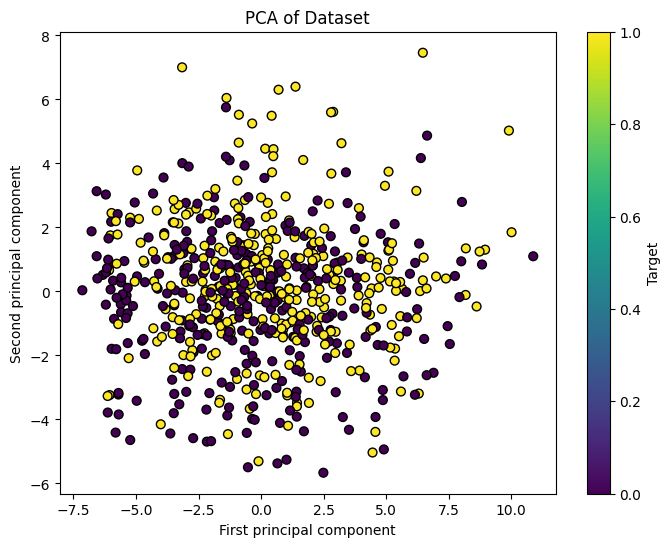

In [ ]:
# Standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of the two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=40)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of Dataset')
plt.colorbar(label='Target')
plt.show()

## Random forest

In [ ]:
# Create the pipeline
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features='sqrt'))
])

In [ ]:
# Fit the model
rf_pipeline.fit(X_train, y_train)

# Predictions and evaluations
y_pred = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Train Score:", rf_pipeline.score(X_train, y_train))
print("Accuracy Test Score:", rf_pipeline.score(X_test, y_test))

# Cross-validation
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5)
print("Average CV Score:", cv_scores.mean())

# NDCG metric
print(f"NDCG score: {ndcg_score(y_test.ravel().reshape(1, -1), y_pred.ravel().reshape(1, -1))}")

              precision    recall  f1-score   support

           0       0.99      0.56      0.72      1495
           1       0.03      0.68      0.06        34

    accuracy                           0.57      1529
   macro avg       0.51      0.62      0.39      1529
weighted avg       0.97      0.57      0.70      1529

Confusion Matrix:
 [[843 652]
 [ 11  23]]
Accuracy Train Score: 0.9580745341614907
Accuracy Test Score: 0.566383257030739
Average CV Score: 0.6443677325581396
NDCG score: 0.41664835918756554


## Preprocessing

In [ ]:
# Define the pre-processing for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale features
])

# Bundle preprocessing for numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

## Logistic regression

In [ ]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', C=0.1, solver='liblinear', max_iter=1000)),
])

In [ ]:
# Fit the model
logreg_pipeline.fit(X_train, y_train)

# Predictions and evaluations
y_pred = logreg_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Train Score:", logreg_pipeline.score(X_train, y_train))
print("Accuracy Test Score:", logreg_pipeline.score(X_test, y_test))

# Cross-validation
cv_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5)
print("Average CV Score:", cv_scores.mean())

print(f"NDCG score: {ndcg_score(y_test.ravel().reshape(1, -1), y_pred.ravel().reshape(1, -1))}")

              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1495
           1       0.05      0.76      0.09        34

    accuracy                           0.64      1529
   macro avg       0.52      0.70      0.43      1529
weighted avg       0.97      0.64      0.76      1529

Confusion Matrix:
 [[946 549]
 [  8  26]]
Accuracy Train Score: 0.6801242236024845
Accuracy Test Score: 0.6357096141268803
Average CV Score: 0.638202519379845
NDCG score: 0.43877642865002264


## SVC

In [ ]:
# Pipeline for using standard SVC
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(C=1, gamma=0.01, max_iter=10000))  # Using SVC with a linear kernel
])

In [ ]:
# Fit the model
svc_pipeline.fit(X_train, y_train)

# Predictions and evaluations
y_pred = svc_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Train Score:", svc_pipeline.score(X_train, y_train))
print("Accuracy Test Score:", svc_pipeline.score(X_test, y_test))

# Cross-validation
cv_scores = cross_val_score(svc_pipeline, X_train, y_train, cv=5)
print("Average CV Score:", cv_scores.mean())

print(f"NDCG score: {ndcg_score(y_test.ravel().reshape(1, -1), y_pred.ravel().reshape(1, -1))}")

              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1495
           1       0.04      0.62      0.07        34

    accuracy                           0.63      1529
   macro avg       0.51      0.63      0.42      1529
weighted avg       0.97      0.63      0.76      1529

Confusion Matrix:
 [[946 549]
 [ 13  21]]
Accuracy Train Score: 0.8012422360248447
Accuracy Test Score: 0.6324395029431
Average CV Score: 0.6522044573643411
NDCG score: 0.42086126122808665


## MLP

In [ ]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, activation='logistic', alpha=10, solver='lbfgs', random_state=42, early_stopping=True))
])

MLP with L2 regularization. For small datasets ‘lbfgs’ can converge faster and performs better.

In [ ]:
mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_0', 'feature_1',
                                                   'feature_2', 'feature_4',
                                                   'feature_5', 'feature_6',
                                                   'feature_7', 'feature_8',
                                                   'feature_16', 'feature_17',
                                                   'feature_18', 'feature_19',
                                                   'feature_20', 'feature_21',
                                                   'feature_22', 'feature_23',
                                                   'feature_24', 'feature_25',
                                                   'feature_26', 'feature_27',
                                                   'feature_28', 'feature_29',
                                                   'feature_30', 'feature_31',
                                                   'feature_32', 'feature_33',
                                                   'feature_34', 'feature_35',
                                                   'feature_36', 'feature_37', ...])])),
                ('classifier',
                 MLPClassifier(activation='logistic', alpha=10,
                               early_stopping=True, hidden_layer_sizes=(50,),
                               max_iter=100, random_state=42,
                               solver='lbfgs'))])

In [ ]:
# Predictions and evaluations
y_pred = mlp_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Train Score:", mlp_pipeline.score(X_train, y_train))
print("Accuracy Test Score:", mlp_pipeline.score(X_test, y_test))
print(f"NDCG score: {ndcg_score(y_test.ravel().reshape(1, -1), y_pred.ravel().reshape(1, -1))}")

              precision    recall  f1-score   support

           0       0.99      0.64      0.77      1495
           1       0.04      0.71      0.08        34

    accuracy                           0.64      1529
   macro avg       0.52      0.67      0.43      1529
weighted avg       0.97      0.64      0.76      1529

Confusion Matrix:
 [[950 545]
 [ 10  24]]
Accuracy Train Score: 0.6909937888198758
Accuracy Test Score: 0.6370176586003924
NDCG score: 0.43214574227842023


In [ ]:
# Cross-validation
cv_scores = cross_val_score(mlp_pipeline, X_train, y_train, cv=5)
print("Average CV Score:", cv_scores.mean())

Average CV Score: 0.630499031007752


## MLP with dropout

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

In [ ]:
class MLP100(nn.Module):
    def __init__(self, num_features, drop_rate=0.8):
        super(MLP100, self).__init__()
        self.layers = nn.Sequential()

        # Add the layers dynamically
        for i in range(100):  # 100 layers
            if i == 0:
                self.layers.add_module(f"linear_{i}", nn.Linear(num_features, num_features))
            else:
                self.layers.add_module(f"dropout_{i-1}", nn.Dropout(drop_rate))
                self.layers.add_module(f"linear_{i}", nn.Linear(num_features, num_features))
            self.layers.add_module(f"relu_{i}", nn.ReLU())

        self.output = nn.Linear(num_features, 2)  # Binary classification

    def forward(self, x):
        x = self.layers(x)
        x = self.output(x)
        return x

In [ ]:
# Instantiate the model
model = MLP100(num_features=79)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Closure for LBFGS
    def closure():
        return loss

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step(closure)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.6932
Epoch [20/50], Loss: 0.6947
Epoch [30/50], Loss: 0.6951
Epoch [40/50], Loss: 0.6929
Epoch [50/50], Loss: 0.6948


In [ ]:
# Predict on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Convert predictions and true values to NumPy arrays for evaluation with scikit-learn
predicted_np = predicted.numpy()
y_test_np = y_test_tensor.numpy()

# Evaluation metrics
print(classification_report(y_test_np, predicted_np))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, predicted_np))
print("Accuracy Score:", accuracy_score(y_test_np, predicted_np))
print(f"NDCG score: {ndcg_score(y_test_np.reshape(1, -1), predicted_np.reshape(1, -1))}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1495
           1       0.02      1.00      0.04        34

    accuracy                           0.02      1529
   macro avg       0.01      0.50      0.02      1529
weighted avg       0.00      0.02      0.00      1529

Confusion Matrix:
 [[   0 1495]
 [   0   34]]
Accuracy Score: 0.02223675604970569
NDCG score: 0.3899032693596343


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Choosing and downloading model

```
              precision    recall  f1-score   support

           0       0.99      0.64      0.77      1495
           1       0.04      0.71      0.08        34

    accuracy                           0.64      1529
   macro avg       0.52      0.67      0.43      1529
weighted avg       0.97      0.64      0.76      1529


Accuracy Train Score: 0.6909937888198758
Accuracy Test Score: 0.6370176586003924
NDCG score: 0.43214574227842023
```

In [ ]:
# Save the model to a file
dump(mlp_pipeline, 'mlp_pipeline.joblib')

['mlp_pipeline.joblib']